In [34]:
from typing import TypeVar, Generic, NewType
from abc import ABC, abstractmethod
from dataclasses import dataclass

S = TypeVar('S')

# abstract state class
class State(ABC, Generic[S]):
    def __init__(self, state: S) -> None:
        self.state = state
    
    @property
    @abstractmethod
    def isTerminal(self):
        pass
        
NonTerminal = State # for annotation convenience
Terminal    = State
        
# abstract environment class
class Environment(ABC, Generic[S]):
    def __init__(self, initial_state: State[S]) -> None:
        self.state : State[S] = initial_state
    
    @abstractmethod
    def reset(self) -> None:
        pass
       
    @abstractmethod
    def step(self, execution_mode) -> State[S]:
        pass

In [35]:
class UnderlyingStochasticProcess(ABC):
    '''
        Abstract class for stochastic process
    '''
    def __init__(self, start_price: float):
        self.price = start_price
        
    @abstractmethod
    def next_state(self):
        pass
    
# for annotation convenience
Price, Revenue = NewType('Price', float), NewType('Revenue', float)
    
class Almgren_Chriss_ABM(UnderlyingStochasticProcess):
    '''
        Specify underlying evolution process
        on Almgren-Chriss model with params:
        sigma, kappa, eta
    '''
    def __init__(self, 
                 start_price: float,
                 daily_volume: int,
                 env_sigma: float,
                 env_kappa: float,
                 env_eta: float
                 ) -> None:
        self.start_price  = start_price
        self.price        = start_price
        self.env_sigma = env_sigma   # volatility of the ABM process
        self.env_kappa = env_kappa   # permanent market impact parameter
        self.env_eta   = env_eta     # temporary price impact parameter
        
    def reset(self) -> None:
        self.price = self.start_price
      
    def next_state(self, dt: float, sqrt_dt: float, trading_rate: float, 
            frozen_price: bool = False) -> Revenue:
        revenue = -trading_rate * (self.price + self.env_eta * trading_rate) * dt
        if frozen_price:
            return revenue
        else:
            self.price += self.env_kappa * trading_rate * dt\
                + self.start_price * np.random.normal(loc=0, scale=sqrt_dt * self.env_sigma) 
            return revenue

In [36]:
from typing import Tuple
import itertools
from copy import deepcopy

@dataclass
class Inventory_Execution_State:
    '''
        Container for portfolio execution state:
        initial inventory -> target inventory
        accounting current inventory and remaining time.
    '''
    initial_inventory : int   = 1
    target_inventory :  int   = 0
    current_inventory : float = 1
    remaining_time :    float = 1
    
    @property
    def isTerminal(self) -> bool:
        '''
            The terminal condition allows us use the class 
            as for portfolio liquidation
            as well as for portfolio acquisition
        '''
        return abs(self.current_inventory - self.target_inventory) < 1e-3\
                or self.remaining_time < 1e-6

class ExecutionEnvironment(Environment[Inventory_Execution_State]):
    '''
        Specification for Environment parameterized with
        execution state class. It uses state container
        and stochastic process so both can be chosen
        arbitrary for different state and processes types.
    '''
    
    def __init__(self, 
                 initial_state: Inventory_Execution_State,
                 process: Almgren_Chriss_ABM
        ) -> None:
        self.__initial_state = deepcopy(initial_state)
        self.state           = deepcopy(initial_state)
        self.process         = deepcopy(process)
    
    def reset(self) -> Price:
        self.state = deepcopy(self.__initial_state)
        self.process.reset()
        return self.process.price
    
       
    def step(self, order: int, exec_time: float, 
             dt: float, frozen_price: bool = False
        ) -> Tuple[Price, Revenue]:
        '''
            On each step agent executes inventory with order size.
            Step takes exec_time for the execution.
            If order is being executed evenly every dt 
            then we have (exec_time/dt) equivalent orders to execute.
            Frozen_time is responsible for price impact while order is executed.
        '''
        # if we execute larger order then remained inventory
        # or required time is greater than remained -> decrease it
        inv_diff = self.state.current_inventory + order
        if inv_diff < -1e-5:
            order -= inv_diff
            #print(f'Order was decreased by {inv_diff}, order = {order}')
        time_diff = self.state.remaining_time - exec_time
        if time_diff < -1e-5:
            exec_time += time_diff
            #print(f'Order is going to be executed by {-time_diff} faster, execution time = {exec_time}')
        
        sqrt_dt = np.sqrt(dt)
        trading_rate = order / (exec_time + 1e-10) 
        #print(f'trading_rate = {trading_rate}')
        orders = int( exec_time / dt ) # number of orders is integer
        revenue = 0
        for i in range(orders):
            revenue += self.process.next_state(dt, sqrt_dt, trading_rate, frozen_price)
        # update state
        if frozen_price:
            return self.process.price, revenue
        self.state.current_inventory += order
        self.state.remaining_time    -= exec_time
        
        return self.process.price, revenue

In [38]:
from typing import List
import numpy as np

# AC agent
class AC_agent:
    '''
        the agent decides what size of market order to execute
        according to Almgren-Chriss model optimal execution
        risk_aversion_lambda is a measure how the agent prefers to act:
        sell instantaneously (lambda ~0) or sell uniformly in time horizon (lambda >> 0)
        dzeta is a measure of willingness to explore (consider as standard deviation in random choosing (acc. Gauss))
        phi : policy parametrization vector
        psy : kappa, eta, sigma approximation vector
        theta: value-function parametrization vector
    '''
    def __init__(self,
                 risk_aversion_lambda: float, 
                 dzeta: float,
                 phi: np.ndarray, 
                 psy: np.ndarray,
                 theta: np.ndarray
            ) -> None:
        self.ra_lambda = risk_aversion_lambda
        self.dzeta     = dzeta
        self.phi       = deepcopy(phi)
        self.psy       = deepcopy(psy)
        self.M_phi     = np.eye(3)
        self.M_phi_inv = np.eye(3)
        self.theta     = deepcopy(theta)
        self.theta_t   = deepcopy(theta)
        
    def get_mu(self, inventory: float, T: float, t: float) -> float: 
        return -inventory * self.phi[0] / ( np.tanh( self.phi[0] * (T - t) ) + 1e-10 )

    def get_sigma(self):
        return self.dzeta * self.phi[1]
        
    def get_action(self, inventory: float, T: float, t: float) -> float:
        action = np.random.normal(
                    loc= self.get_mu(inventory, T, t),
                    scale=self.get_sigma()
        )
        return action
    
    # update matrixes independently since we have to control the update order!
    def update_M_phi(self, price_S0: float) -> None:
        self.M_phi[1,1], self.M_phi[2,1] = self.phi[0], self.phi[0]
        self.M_phi[1,2], self.M_phi[2,2] = self.ra_lambda * price_S0 ** 2 / self.phi[0], -self.ra_lambda * price_S0 ** 2 / self.phi[0]
    
    def update_M_phi_inv(self, price_S0: float) -> None:
        self.M_phi_inv[1,1], self.M_phi_inv[1,2] = 1 / 2 / self.phi[0], 1 / 2 / self.phi[0]
        self.M_phi_inv[2,1], self.M_phi_inv[2,2] = self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2, -self.phi[0] / 2 / self.ra_lambda / price_S0 ** 2
        
    def update_psy(self) -> None:
        self.psy = np.dot(self.M_phi_inv, self.theta_t)
        
    def g_function(self, trade_horizon: float) -> None:
        f_term = 1 / np.tanh(self.phi[0] * trade_horizon) / self.phi[0]
        s_term = trade_horizon / np.sinh(self.phi[0] * trade_horizon) ** 2
        t_term = -2 * self.phi[0] * trade_horizon ** 2 / np.sinh(self.phi[0] * trade_horizon) ** 2\
                    / np.tanh(self.phi[0] * trade_horizon) 
        return f_term + s_term + t_term
    
    def value_function(self, T: float, t: float, 
                       inventory: float, price_S: float) -> None:
        f_term = inventory * price_S
        s_term = self.dzeta / 2 * ( np.log(2 * np.pi * np.exp(1) * self.dzeta * self.phi[1])\
                    - (self.theta[1] + self.theta[2]) * self.phi[1] / self.phi[0] ) * (T - t)
        t_term = -inventory ** 2 / 2 * ( self.theta[0] + self.theta[1] / np.tanh(self.phi[0] * (T - t))\
                    + self.theta[2] * self.phi[0] * (T - t) / (np.sinh(self.phi[0] * (T - t))) ** 2 )
        return f_term + s_term + t_term

In [39]:
def compare_to_true(phi, theta, env_sigma, env_kappa, env_eta, price_S0
                   ) -> None:
    '''
        compare calculated true value of phi vector (optimal parametrization) 
        and the agent phi vector (that we've got from learning algorithm)
    '''
    true_phi_1   = np.sqrt(risk_aversion_lambda * env_sigma**2 * price_S0**2 / env_eta)
    true_phi_2   = 1 / 2 / env_eta
    true_theta_1 = env_kappa
    true_theta_2 = true_phi_1 * env_eta + risk_aversion_lambda * price_S0**2 * env_sigma**2 / true_phi_1
    print(f'''for chosen env params:
    true phi = {true_phi_1, true_phi_2}, true theta = {true_theta_1, true_theta_2, 0}
    agent params: phi = {phi}, theta = {theta}
    ''')
    
def return_optimal_params(
    env_sigma: float, env_kappa: float, env_eta: float, price_S0: float
) -> List[np.ndarray]:
    true_phi_1   = np.sqrt(risk_aversion_lambda * env_sigma**2 * price_S0**2 / env_eta)
    true_phi_2   = 1 / 2 / env_eta
    true_theta_1 = env_kappa
    true_theta_2 = true_phi_1 * env_eta + risk_aversion_lambda * price_S0**2 * env_sigma**2 / true_phi_1
    return np.array([true_phi_1, true_phi_2]), np.array([true_theta_1, true_theta_2, 0])

In [45]:
from typing import Callable
from scipy.special import roots_hermite
import matplotlib.pyplot as plt

# Exploratory Mean Quadratic Variance algorithm
class EMQV:
    
    def __init__(self, env: ExecutionEnvironment, agent: AC_agent):
        self.env   = env
        self.agent = agent
        
    def simulate(self, 
                 inventory_q0:      int,
                 N_trades:          int,
                 learning_epochs:   int,
                 learning_episodes: int,
                 explor_grid_nodes: int,
                 alpha_phi:         np.ndarray, 
                 alpha_t:           float,
                 ap_update_rule:    Callable[[float, int], float],
                 at_update_rule:    Callable[[float, int], float],
                 phi_field:         np.ndarray,
                 theta_field:       np.ndarray,
                 render:            bool = False,
                 verbose:           bool = False
                ):
        
        # constants
        PI  = np.pi
        EXP = np.exp(1) 
        
        # params
        exec_time = self.env.state.remaining_time
        dt        = exec_time / N_trades
        
        # for Gauss-Hermite quadrature
        abscissas_y, weights_w = roots_hermite(explor_grid_nodes, mu=False)

        reward_vector          = np.zeros(explor_grid_nodes, dtype=float)
        rewards      = np.zeros(learning_episodes, dtype=float)
        price_change = np.zeros(learning_episodes, dtype=float)
        
        print(f'\nAgent with phi = {self.agent.phi}\ntheta = {self.agent.theta}\n')
        
        
        for epoch in range(learning_epochs):
            theta_grad = np.zeros(3, dtype=float)
            
            print(f'Learning epoch = {epoch}')
            
            for episode in range(learning_episodes):
                
                # drop to initial env state
                price_S              = self.env.reset()
                inventory_q          = inventory_q0
                price_trajectory     = np.zeros(N_trades + 1, dtype=float)
                inventory_trajectory = np.zeros(N_trades + 1, dtype=float)
                exploratory_reward   = np.zeros(N_trades, dtype=float)
                delta_P              = np.zeros(N_trades, dtype=float)
                sq_delta_P           = np.zeros(N_trades, dtype=float)
                rewards_trajectory   = np.zeros(N_trades, dtype=float)
                
                # run execution !
                for time_step in range(N_trades):
                    # calculate mean and variance of policy ~ N(mu, sigma)
                    mu    = self.agent.get_mu(inventory_q, exec_time, dt * time_step)
                    sigma = self.agent.dzeta * agent.phi[1]
                    
                    for j in range(explor_grid_nodes):
                        trading_rate_v = mu + np.sqrt(2) * sigma * abscissas_y[j]
                        _, reward_vector[j] = self.env.step( trading_rate_v * dt, dt, dt, frozen_price=True ) # = order size inside

                    # calculate exploratory reward
                    exploratory_reward[time_step] = np.dot(weights_w, reward_vector) / np.sqrt(PI)
                    
                    # execute the order
                    order = mu * dt
                    next_price_S, revenue = self.env.step(order, dt, dt, False)

                    # calculate sq_delta_P 
                    delta_P[time_step] = ( exploratory_reward[time_step] + price_S * order + inventory_q * (next_price_S - price_S) ) 
                    sq_delta_P[time_step] = delta_P[time_step] ** 2
                    
                    #print(f'\ndelta_P = {delta_P[time_step]}, sq_delta_P = {sq_delta_P[time_step]}')
                    #print(f'exact QV = {(self.env.process.env_sigma**2)*(self.env.process.start_price**2)*(inventory_q**2)*dt}')
                    #print(f'exact/app = {sq_delta_P[time_step]/(self.env.process.env_sigma**2)*(self.env.process.start_price**2)*(inventory_q**2)*dt}\n')

                    
                    # add price and inventory movements to trajectories 
                    price_trajectory[time_step]     = price_S 
                    inventory_trajectory[time_step] = inventory_q
                    rewards_trajectory[time_step]   = revenue
                    
                    # update inventory and price values 
                    inventory_q += order 
                    price_S      = next_price_S
                    
                    if verbose:
                        print(f'mu = {mu}, dt = {dt}, order = {order}')
                        print(f'revenue = {revenue}')
                
                # to set the last trajectories elems: current price, zero inventory
                price_trajectory[time_step + 1]     = price_S 
                inventory_trajectory[time_step + 1] = inventory_q # it may be <0 !
                price_change[episode] = price_S
                rewards[episode] = rewards_trajectory.sum()
                
                #print(f'last inventory = {inventory_trajectory[time_step + 1]}')
                #print(f'\n exp rew = {exploratory_reward}\n')
                

                #========== the end of execution episode ==========#
            
                #========== policy evaluation ==========#

                # drop to zero 3d-gradient for ML, Vi on each episode 
                d_theta_ML = np.zeros(3, dtype=float)
                d_theta_Vi = np.zeros((3, N_trades), dtype=float)

                # calculate theta_gradient using (30,31,32,33)
                tis = np.arange(N_trades)
                d_theta_Vi[0] = - np.square(inventory_trajectory[:-1]) / 2
                d_theta_Vi[1] = d_theta_Vi[0] / np.tanh(self.agent.phi[0] * (exec_time - tis * dt))\
                    - self.agent.dzeta * self.agent.phi[1] / (2 * self.agent.phi[0]) * (exec_time - tis * dt)
                d_theta_Vi[2] = d_theta_Vi[0] * self.agent.phi[0] * (exec_time - tis * dt)\
                                        / (np.sinh(self.agent.phi[0] * (exec_time - tis * dt))) ** 2\
                                        - dzeta * self.agent.phi[1] / (2 * self.agent.phi[0]) * (exec_time - tis * dt)

                for ti in range(N_trades):
                    # for each partial derivative add sum from j = ti to N-1
                    temp_part_term = np.sum(exploratory_reward[ti:] - sq_delta_P[ti:] * self.agent.ra_lambda)
                    #print(f'temp_term = {temp_part_term}') # CORRECT
                    #print(f'params = {self.agent.phi, self.agent.theta}')
                    #print(f'val f = {self.agent.value_function(exec_time, ti * dt, inventory_trajectory[ti], price_trajectory[ti])}')

                    for k in range(3):
                        
                        diff = -2 * dt * d_theta_Vi[k][ti]\
                        * (-self.agent.value_function(exec_time, ti * dt, inventory_trajectory[ti], price_trajectory[ti])\
                           + self.agent.dzeta * (exec_time - ti * dt) * np.log(np.sqrt(2 * PI * EXP * self.agent.dzeta * self.agent.phi[1]))\
                           + temp_part_term)
                            
                        d_theta_ML[k] += diff

                        #print(f'diff = {diff}')
                    
                    #print(f'2nd term = {self.agent.dzeta * (exec_time - ti * dt) * np.log(np.sqrt(2 * PI * EXP * self.agent.dzeta * self.agent.phi[1]))}')
                    #print(f'param: {exec_time - ti * dt, inventory_trajectory[ti], price_trajectory[ti]}')
                    #print(f'val f = {self.agent.value_function(exec_time, ti * dt, inventory_trajectory[ti], price_trajectory[ti])}')
                    #print(f'\nd_theta_ML = {d_theta_ML}\n')

                # according to (30) mult (-2) the d_theta_ML then add to total sum of theta_grad
                for k in range(3):
                    #d_theta_ML[k] *= (-2) * dt
                    theta_grad[k] += d_theta_ML[k]
            print(f'theta_grad init = {theta_grad}')
                    
            #========== end of learning episodes ==========#
        
            # calculate theta gradient and update theta
            theta_grad = theta_grad / learning_episodes
                
            alpha_t = max(abs(theta_grad))
            print(alpha_t)
            alpha_t = np.max(abs(alpha_t / (theta_field.T - self.agent.theta_t).T))
            print(f'alpha_t = {alpha_t}')
                
            self.agent.theta_t = self.agent.theta - theta_grad / alpha_t * at_update_rule(epoch)
            
            if epoch % 1 == 0:
                print(f'theta_grad = {theta_grad / alpha_t}')
                print(f'theta_t = {self.agent.theta_t}')

            #========== policy gradient ==========#

            # construct inv_M(Ф)_l
            self.agent.update_M_phi_inv(self.env.process.start_price)

            # construct psy = inv_M * theta = [ kappa_imp, eta_imp, sigma**2_imp ]
            self.agent.psy = np.dot(self.agent.M_phi_inv, self.agent.theta)
            
            print(f'kappa, eta, sigma**2 = {self.agent.psy}')

            print(f'g = {self.agent.g_function(exec_time)}')
            
            # calc dphi_G
            # XXX: why we should average the grad if it doesn't depend on learning episode?
            print(f'theta = {self.agent.theta}')
            print(f'g = {self.agent.g_function(exec_time)}')
            d_phi1_G  = - inventory_q0 ** 2 * self.agent.theta[2] / 2 * self.agent.g_function(exec_time)
            d_phi2_G  = self.agent.dzeta * exec_time * ( 1 / 2 / self.agent.phi[1] - (self.agent.theta[1] + self.agent.theta[2]) / 2 / self.agent.phi[0] )

            alpha_phi[0] = max(abs(d_phi1_G / (phi_field[0][1] - self.agent.phi[0])), 
                               abs(d_phi1_G / (phi_field[0][0] - self.agent.phi[0])))
            alpha_phi[1] = max(abs(d_phi2_G / (phi_field[1][1] - self.agent.phi[1])), 
                               abs(d_phi2_G / (phi_field[1][0] - self.agent.phi[1])))
            
            print(f'alpha_phi = {alpha_phi}')
            
            if epoch % 1 == 0:
                print(f'd_G grad init = {d_phi1_G, d_phi2_G}')
                print(f'd_G grad = {d_phi1_G / alpha_phi[0], d_phi2_G / alpha_phi[1]}')

            # update phi
            self.agent.phi[0] += d_phi1_G * ap_update_rule(epoch) #/ alpha_phi[0] 
            self.agent.phi[1] += d_phi2_G * ap_update_rule(epoch) #/ alpha_phi[0] 
            
            if epoch % 1 == 0:
                print(f'new phi = {self.agent.phi}\n')

            #========== the end of policy gradient ==========#

            #========== recalibration ==========#

            # construct M(Ф)_l+1
            self.agent.update_M_phi(self.env.process.start_price)

            # update theta
            self.agent.theta = np.dot(np.dot(self.agent.M_phi, self.agent.M_phi_inv),self.agent.theta_t )
            self.agent.update_M_phi_inv(self.env.process.start_price)
            
            #========== the end of recalibration ==========#

        if render:
                plt.plot(price_trajectory, label='price')
                plt.legend()
                plt.show()

                plt.plot(inventory_trajectory, label='inventory')
                plt.legend()
                plt.show()

                plt.plot(rewards_trajectory, label=f'revenue\nMean total = {rewards.mean()}')
                plt.legend()
                plt.show()

                plt.plot(price_change, label=f'Price on the end of trade episode\nE[dS] = {price_change.mean()-price_S:.5f}\nS mean = {price_change.mean():.5f}\nsigma(scaled to 1 day) = {self.env.process.env_sigma:.5f}')
                plt.legend()
                plt.show()
                

        print(f'Learned agent with\nphi = {self.agent.phi},\ntheta={self.agent.theta}')

Optimal params: phi = [3.16227766e+02 5.00000000e+05], theta = [2.50000000e-07 6.32455532e-04 0.00000000e+00]

Agent with phi = [100, 100]
theta = [0.1 0.1 0.1]

Learning epoch = 0
theta_grad init = [1.40073562e+10 4.78216749e+10 4.48696995e+10]
956433497.1163611
alpha_t = 1062703885.6848457
theta_grad = [0.2636173  0.9        0.84444407]
theta_t = [0.07363827 0.01       0.01555559]
kappa, eta, sigma**2 = [ 1.00000000e-01  1.00000000e-03 -1.11022302e-16]
g = 0.00010624544143840453
theta = [0.1 0.1 0.1]
g = 0.00010624544143840453
alpha_phi = [1.77075736e-01 1.76366843e-07]
d_G grad init = (-5.312272071920226, 1.5873015873015872e-05)
d_G grad = (-30.000000000000004, 90.0)
new phi = [94.68772792807977, 100.00001587301587]

Learning epoch = 1
theta_grad init = [2.94778042e+09 1.03920446e+10 9.79532967e+09]
207840891.75606582
alpha_t = 224362562.82893714
theta_grad = [0.26276937 0.92636173 0.87316971]
theta_t = [ 0.04762279 -0.08254906 -0.07141551]
kappa, eta, sigma**2 = [ 0.07363827  0.000

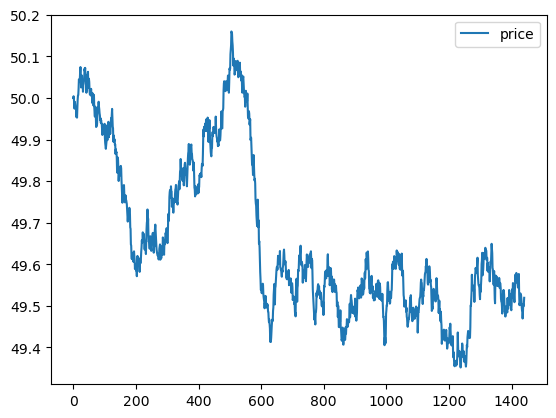

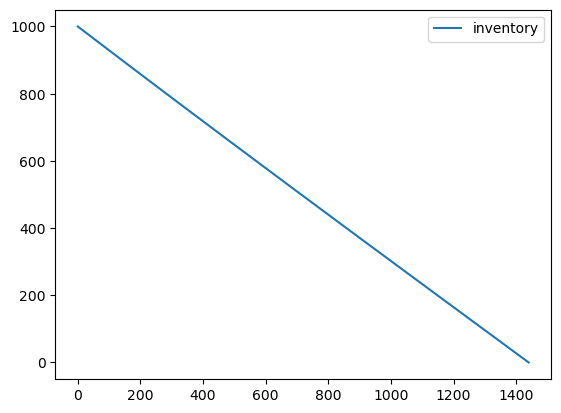

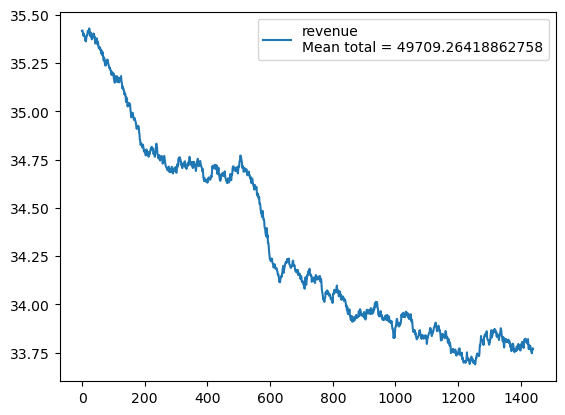

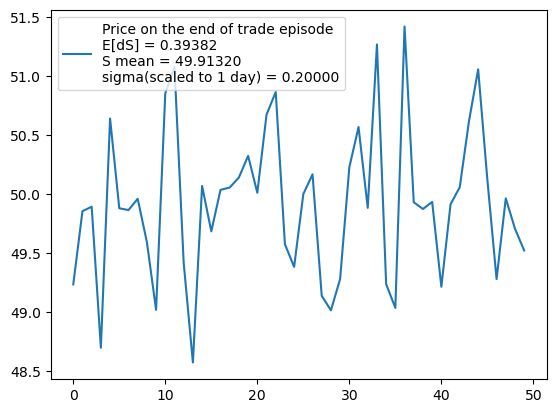

Learned agent with
phi = [68.96144497159293, 100.00191866977376],
theta=[0.01516218 0.00204732 0.06517564]
CPU times: user 8min 39s, sys: 3.28 s, total: 8min 43s
Wall time: 8min 39s


In [49]:
%%time

#-------------------------------------#
# Exploratory Mean Quadratic Variance
#-------------------------------------#

#-------------------------------------#
# ENVIRONMENT SET UP
#-------------------------------------#

# inventory params
start_price = 50
inventory_q0 = 1000
daily_volume = 50_000
bid_ask_spread = 1/8

# time parameters
execution_horizon = 1 # days
execution_time    = execution_horizon / 252   # there are 250 days per trading year
N_trades          = execution_horizon * 24 * 60 # 10min periods per day
dt                = execution_time / N_trades

# Env arbitrary params (have to be estimated from historical data)
env_sigma = 0.2
env_kappa = 2.5 * 1e-7
env_eta   = bid_ask_spread / (0.01 * daily_volume * 250) # for aech 1% of daily volume

# create environment
#env = AC_simulator(price_S0, execution_time, dt, env_sigma, env_kappa, env_eta)
sf = Inventory_Execution_State(inventory_q0, 0, inventory_q0, execution_time)
pr = Almgren_Chriss_ABM(start_price, daily_volume, env_sigma, env_kappa, env_eta)
env = ExecutionEnvironment(sf, pr)


#=====================================#

#-------------------------------------#
# AGENT SET UP
#-------------------------------------#

# agent arbitrary params, lambda depends on env_eta
risk_aversion_lambda = 1e3 * env_eta
phi   = np.array([3, 2], dtype=float)
psy   = np.zeros(3, dtype=float)
theta = np.array([0.01, 0.01, -0.01], dtype=float)

true_phi, true_theta = return_optimal_params(env_sigma, env_kappa, env_eta, start_price)
phi_field = np.array([[130, 230], [10, 1_000_000]])
theta_field = np.array([[-1, 1], [-1, 1], [-1, 1]])
                 
phi, theta = return_optimal_params(env_sigma, env_kappa, env_eta, start_price)
dzeta = 1
phi = [100, 100]
theta = np.array([0.1, 0.1, 0.1], dtype=float)
print(f'Optimal params: phi = {true_phi}, theta = {true_theta}')

# create agent
agent = AC_agent(risk_aversion_lambda, dzeta, phi, psy, theta)

#=====================================#

#-------------------------------------#
# SIMULATION SET UP
#-------------------------------------#

agent = AC_agent(risk_aversion_lambda, dzeta, phi, psy, theta)
env = ExecutionEnvironment(sf, pr)
# simulation params
learning_epochs   = 100
learning_episodes = 50
explor_grid_nodes = 10
alpha_phi = np.array([inventory_q0, 1], dtype=float)
alpha_t   = 1 #np.array([1, inventory_q0**2, inventory_q0**2])
ap_update_rule = lambda i: np.exp(-0.001*i)
at_update_rule = lambda i: np.exp(-0.01*i) / 10

emqv = EMQV(env, agent) # add verbose param
emqv.simulate(inventory_q0, N_trades, 
                  learning_epochs, learning_episodes,
                  explor_grid_nodes, alpha_phi, alpha_t,
                  ap_update_rule, at_update_rule,
                  phi_field, theta_field,
                  render=True, verbose=False)